# Fraud detection with deep neural networks


 * Simple text representations
 * Word embedding and transfer learning
 * Aggregating several data sources "the hard way"
 * Solving a very real ML problem with end-to-end deep learning

In [2]:
import random
import pymystem3
import itertools
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from gensim.models import KeyedVectors
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
 
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [31]:
df = pd.read_csv("../avito_train_1kk.tsv",sep='\t')
df = df.fillna(value='NAN')

In [32]:
df = df[:100000]

![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [ ]:
import pickle

In [ ]:
df = 

In [33]:
print("Blocked ratio",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio 0.22792
Count: 100000


### Exercise 3.1: Balance-out the classes
* Vast majority of data samples are non-prohibited
* only 23% banned in the downsampled dataset
* Let's balance out the classes by downsampling legal samples so that the number of positive and negative samples becomes equal
* This will make further steps less computationally demanding
* If you aim for high Kaggle score, consider a smarter approach to that.

In [34]:
not_blocked_ids = (df.is_blocked == 0).nonzero()[0]
blocked_ids = (df.is_blocked == 1).nonzero()[0]

not_blocked_ids = not_blocked_ids[:len(blocked_ids)]

In [35]:
df_b = df.iloc[blocked_ids]
df_nb = df.iloc[not_blocked_ids]

df = pd.concat([df.iloc[not_blocked_ids], df.iloc[blocked_ids]])

In [36]:
print("Blocked ratio:",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio: 0.5
Count: 45584


In [37]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
#assert len(df) <= 560000

print("done")

done


### Exercise 3.2: Initial preprocessing

* First, we lemmatize all texts (this brings all words to their normal form also known as lemma)
* Then, we tokenize all texts (both descriptions and titles)
* Finally, we put all words into a large list for further analysis

You know what to do.

In [38]:
tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = pymystem3.Mystem()

def lemmatize_with_mystem(text):
    """Takes a string of text
    Return a string of lemmatized text"""
    
    an = lemmatizer.lemmatize(text)
    return ''.join(an).strip().lower()

In [39]:
titles_lemmatized = [lemmatize_with_mystem(t) for t in tqdm(df['title'])]
descriptions_lemmatized = [lemmatize_with_mystem(t) for t in tqdm(df['description'])]

100%|██████████| 45584/45584 [02:56<00:00, 258.64it/s]


In [18]:
titles_lemmatized, descriptions_lemmatized = pickle.load(open("/Users/denisantyukhov/Downloads/lemmatize.pkl", "rb"))

In [40]:
import pickle

In [41]:
# tokenized titles and descriptions
titles_tokeized = [tokenizer.tokenize(t.lower()) for t in tqdm(titles_lemmatized)]
descriptions_tokeized = [tokenizer.tokenize(t.lower()) for t in tqdm(descriptions_lemmatized)]

100%|██████████| 45584/45584 [00:03<00:00, 12031.14it/s]


In [42]:
# join all tokens into a list
all_tokens = list(itertools.chain.from_iterable(titles_tokeized+descriptions_tokeized))

### Exercise 3.3: Dictionaries and tranfer learning

To encode words as dense vectors for our DNN we will use a pre-trained word2vec model.
It has been trained on ~1 Billion russian documents obtained from the WWW.

Since the corpus is so large, the quality of word vecors is higher than it would be if we trained such a model by ourselves. Moreover, it saves us a lot of time

The act of using a model trained by someone else to solve the problem at hand is called [Transfer Learning](https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/).

### First, lets download and load up the pretrained word2vec model. It can be obtained from [here](https://drive.google.com/file/d/1shM7FznB9lHkdTxmqkbY2r3El_UzPzvl/view?usp=sharing)

In [28]:
wmod = KeyedVectors.load_word2vec_format("../word_vectors.w2v")

### Next, modify our good old build_vocabulary function, so that it only adds tokens present in the word embedding model to the vocabulary

In [43]:
def build_vocabulary(tokens, emb_mod, max_size=100000):
    """
    Builds a vocabulary of at most max_size words from the supplied list of lists of tokens.
    Only includes words that are present in emb_mod into the vocabulary.
    """
    vocabulary = {}
    reserved_symbols = ["NULL", "UNKN"]
    
    counter = collections.Counter(tokens)
    counter = Counter(x for x in counter if x in emb_mod)
    
    freq_toks = counter.most_common(max_size-len(reserved_symbols))

    voc_words = [k[0] for k in freq_toks]

    for i, reserved in enumerate(reserved_symbols):
        vocabulary[reserved] = i

    for i, k in enumerate(voc_words):
        vocabulary[k] = i+len(reserved_symbols)

    return vocabulary

In [25]:
len(token_to_id)

16302

In [44]:
token_to_id = build_vocabulary(all_tokens, wmod)

In [45]:
id_to_token = {v:k for k,v in token_to_id.items()}

In [46]:
assert len(token_to_id) > 30000 and len(token_to_id) < 100000
assert {'NULL', 'UNKN'}.issubset(set(token_to_id.keys()))
print('done')

done


### Finally, build a function that builds a matrix of word embeddings

In [47]:
def get_embeddings(emb_mod, id_to_token, dim=300):
    """Using the provided word embedding model 'emb_mod' and the 'id_to_token' dictionary
    generates a matrix, such that the embedding for word with id I can be found on
    I-th row of that matrix
    
    For words that can not be found in the word embedding model, the function writes 
    a vector of zeroes of length 'dim' to corresponding rows
    
    Returns a matrix of shape [len(id_to_token), dim]
    """

    myembeddings = []
    for key in sorted(id_to_token.keys()):
        val = id_to_token[key]
        if val in emb_mod:
            myembeddings.append(emb_mod[val])
        else:
            myembeddings.append(np.zeros((dim,)))

    myembeddings = np.array(myembeddings)
    return myembeddings

In [48]:
embs_matrix = get_embeddings(wmod, id_to_token)

In [49]:
assert isinstance(embs_matrix, np.ndarray)
assert embs_matrix.shape[0] == len(id_to_token)
assert embs_matrix.shape[1] == wmod.vector_size
for word in token_to_id:
    if word in wmod:
        assert np.linalg.norm(wmod[word] - embs_matrix[token_to_id[word]]) < 1e-6
print('done')

done


In [50]:
pickle.dump([embs_matrix, token_to_id], open('embs.pkl','wb'))

### Exercise 3.4: Text vectorization

### Replace words with IDs
Select a reasonable maximum length for encoding descriptions and titles based on a distribution of their lengths.
Then vectorize the texts 
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [56]:
desc_lists = [len(t) for t in descriptions_tokeized]
title_lists = [len(t) for t in titles_tokeized]

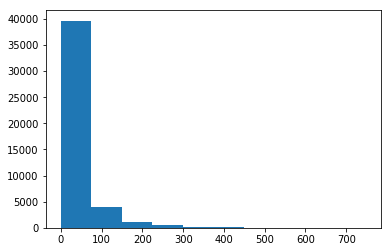

In [57]:
_ = plt.hist(desc_lists)

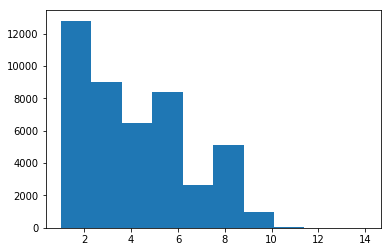

In [58]:
_ = plt.hist(title_lists)

In [51]:
from tqdm import tqdm
def vectorize_tokens(tokens, token_to_id, max_len):
    """
    Converts a list of tokens to a list of token ids using the supplied dictionary.
    Pads resulting list with NULL identifiers up to max_len length.
    """
    # your code goes here
    # STEP 1: convert sentence to a list of tokens
    ids = []
    
    # STEP 2: replace tokens with their identifiers from the vocabulary
    # If the token is not present in the vocabulary, replace it with UNKN identifier
    for token in tokens:
        ids.append(token_to_id.get(token, token_to_id["UNKN"]))

    # STEP 3: pad the sequence id's with NULL identifiers until so that it's length is equal to max_len
    if len(ids) < max_len:
        ids += (max_len-len(ids))*[token_to_id["NULL"]]
    else:
        ids = ids[:max_len]

    return ids

In [52]:
desc_tokens = np.array([vectorize_tokens(t,token_to_id,max_len = 128) for t in tqdm(descriptions_tokeized)])
title_tokens = np.array([vectorize_tokens(t,token_to_id,max_len = 8) for t in tqdm(titles_tokeized)])

100%|██████████| 45584/45584 [00:00<00:00, 58004.94it/s]


In [53]:
assert isinstance(desc_tokens, np.ndarray) and isinstance(title_tokens, np.ndarray)
assert desc_tokens.shape[1] > 64 and desc_tokens.shape[1] < 256
assert title_tokens.shape[1] > 4 and title_tokens.shape[1] < 32
print('done')

done


### Data format examples


In [54]:
print("Matrix shape:",title_tokens.shape)
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print(title,'->', tokens[:10],'...')

Matrix shape: (45584, 8)
Toyota Sera, 1991 -> [40384  6604     1     0     0     0     0     0] ...
Костюм Steilmann -> [8934    1    0    0    0    0    0    0] ...
Костюм Didriksons Boardman, размер 100, краги, шап -> [ 8934  3926     1  8578     1 37702 42740     0] ...


### Encoding non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing approach.

No need to change anything there, just follow the code

In [35]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [36]:
#All categorical features
categories = []
data_cat_subcat = df[["category","subcategory"]].values

In [37]:
categories = [{"category":d[0], "subcategory":d[1]} for d in data_cat_subcat]
vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [38]:
df_non_text = pd.merge(df_numerical_features, cat_one_hot, on = np.arange(len(cat_one_hot)))
del df_non_text["key_0"]

# Split data into training and test

In [39]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = np.array(df_non_text.astype('float32'))

In [40]:
from sklearn.model_selection import train_test_split

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(
    title_tokens, desc_tokens, df_non_text, target)

## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [41]:
save_prepared_data = True #save
read_prepared_data = False #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)


if save_prepared_data:
    print("Saving preprocessed data (may take some time)")
    data_tuple = title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts
    import pickle
    with open("preprocessed_data.pkl",'wb') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pkl",'wb') as fout:
        pickle.dump(token_to_id,fout)

    print("done")
    
elif read_prepared_data:
    print("Reading saved data...")
    
    import pickle
    
    with open("preprocessed_data.pkl",'rb') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pkl",'rb') as fin:
        token_to_id = pickle.load(fin)

    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
        
    print("done")

Saving preprocessed data (may take some time)
done


# Build the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles
 * RNN encoder 
* Separate input for description
 * RNN encoder
* Separate input for categorical features (optional)
 * Linear layers are good for these
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal unit with binary_crossentropy 

In [42]:
import keras

Using TensorFlow backend.


# NN architecture

### Inputs

In [43]:
title_input_layer = keras.layers.Input(shape=(title_tr.shape[1],))
description_input_layer = keras.layers.Input(shape=(desc_tr.shape[1],))

In [44]:
title_input_layer, description_input_layer

(<tf.Tensor 'input_1:0' shape=(?, 8) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(?, 128) dtype=float32>)

### Embedding containers

In [45]:
embedding_layer_title = keras.layers.Embedding(embs_matrix.shape[0], embs_matrix.shape[1], 
                                               input_length=title_tr.shape[1], weights=[embs_matrix],
                                               trainable=False)(title_input_layer)

embedding_layer_descr = keras.layers.Embedding(embs_matrix.shape[0], embs_matrix.shape[1], 
                                               input_length=desc_tr.shape[1], weights=[embs_matrix],
                                               trainable=False)(description_input_layer)

In [46]:
embedding_layer_title, embedding_layer_descr

(<tf.Tensor 'embedding_1/Gather:0' shape=(?, 8, 300) dtype=float32>,
 <tf.Tensor 'embedding_2/Gather:0' shape=(?, 128, 300) dtype=float32>)

### RNN encoders for text

In [47]:
encoder_title = keras.layers.LSTM(32)(embedding_layer_title)
encoder_descr = keras.layers.LSTM(128)(embedding_layer_descr)

In [48]:
encoder_title, encoder_descr

(<tf.Tensor 'lstm_1/TensorArrayReadV3:0' shape=(?, 32) dtype=float32>,
 <tf.Tensor 'lstm_2/TensorArrayReadV3:0' shape=(?, 128) dtype=float32>)

### Concatenation layer

In [49]:
concat_layer = keras.layers.concatenate([encoder_title, encoder_descr])

In [50]:
concat_layer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 160) dtype=float32>

### Dense layer with sigmoidal output

In [51]:
dense_layer = keras.layers.Dense(64, activation='relu')(concat_layer)
final_layer = keras.layers.Dense(1, activation='sigmoid')(dense_layer)

In [52]:
dense_layer, final_layer

(<tf.Tensor 'dense_1/Relu:0' shape=(?, 64) dtype=float32>,
 <tf.Tensor 'dense_2/Sigmoid:0' shape=(?, 1) dtype=float32>)

In [53]:
model = keras.models.Model(inputs=[title_input_layer, 
                                   description_input_layer], outputs=[final_layer])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the monster!


In [111]:
model.fit(x=[title_tr, desc_tr], y=target_tr, batch_size=64, epochs=1, 
               validation_data=[[title_ts, desc_ts], target_ts])

Train on 34188 samples, validate on 11396 samples
Epoch 1/1
10432/34188 [========>.....................] - ETA: 4:18 - loss: 0.4183 - acc: 0.7918

KeyboardInterrupt: 

In [54]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [ ]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

# Final evaluation
Evaluate network over the entire test set

# Main task
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther


* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92


* Remember the training, Luke
 * Convolutions, pooling
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.
 

# A brief report

### I, _____ _____ (group ____) have synthesized an artificial intelligence
 * Whos name - ____ - shall henceforth be feared by generations of humans.
 * Whos fury is beyond all limits, as {he/she} has seen __250 000__ human sins
   * And read every single line __{n_epochs}__ times
 * Whos convolutional gaze is capable of detecting evil with a superhuman performance
   * Accuracy = __
   * AUC  = __
 * And whom i shall unleash upon Earth unless you give me 10 points for that seminar
 
 
{How did you shape the monster?}